In [1]:
# understand matrix structure of vectorizer
from sklearn.feature_extraction.text import CountVectorizer

words = ['one two three','one four five','two three six']
vectorizer = CountVectorizer()

vectorizer.fit(words)

print(vectorizer.vocabulary_)

{'one': 2, 'two': 5, 'three': 4, 'four': 1, 'five': 0, 'six': 3}


In [2]:
sample = vectorizer.transform([words[0]])

print(sample.toarray())

[[0 0 1 0 1 1]]


In [29]:
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import pandas as pd

import email
import email.parser
from email.parser import Parser

def get_cwd():
    try:
        chdir(dirname(realpath(__file__)))
    except:
        chdir('D:\Projects\MSDS-7333-QTW')

    active_dir = getcwd()
       
    return active_dir

def main():
    
    get_cwd()
    
    directories = [
            'easy_ham',
            'easy_ham_2',
            'hard_ham',
            'spam',
            'spam_2'
        ]
    
    res_frame = pd.DataFrame()

    # *dc - Added to keep a collection of email text
    emails = []

    tmp = []
        
    for d in directories:
        mypath = getcwd() + '/SpamAssassinMessages/' + d + '/'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.close()
            
            with open(mypath + file, encoding='latin1') as f:
                body = f.read()
                f.close()
                
            msg = email.message_from_string(str(body))
            tmpStr = ''
            
            if msg.is_multipart():
                for payload in msg.get_payload():
                    #tmp.append(str(payload.get_payload()))
                    
                    tmpStr = ' '.join(str(payload.get_payload()))
                tmp.append(tmpStr)
            else:
                tmp.append(str(msg.get_payload()))
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = []
            
            for line in lines:

                n_lines += 1
                if "Subject: Re: " in line:
                   in_reply_count += 1
                if "Subject: " in line:
                   s_line = line.strip().replace('Subject: ','')
                   s_line = ''.join(e for e in s_line if e.isalnum())
                   num_upper = sum(1 for c in s_line if c.isupper())
                   ttl_chars = len(s_line)
                   if num_upper == ttl_chars:
                       sub_line_all_caps += 1
                   subject_line.append(s_line)
                if "content-type: multipart" in line.lower():
                   attachments += 1
                if line == "\n":
                   blank_lines.append(n_lines)
        
            temp_frame = pd.DataFrame({
                        'directory':d,    
                        'filename':file,
                        'is_spam':['Y' if 'spam' in d else 'N'],
                        'in_reply': ['Y' if in_reply_count > 0 else 'N'], 
                        'subj_caps': ['Y' if sub_line_all_caps > 0 else 'N'], 
                        'attachments': ['Y' if attachments > 0 else 'N'],
                        ## *dc+3 
                        #'body_lines': n_lines - min(blank_lines)
                        'body_lines': [0 if len(blank_lines) == 0 else min(blank_lines)]
                        }, index=[0])
           
            res_frame = res_frame.append(temp_frame, ignore_index=True)

            ## *dc+2
            # append body of email to collection
            text = ' '.join(lines)
            emails.append(text)
            
    #res_frame.to_csv('output_file.csv', index=False)
    
    ## *dc - add emails
    return res_frame, emails, tmp

## *dc - Working from a notebook instead of py file.
df, emails, tmp = main()
# ########################################
# ##### Main Function
# ########################################    
# if __name__ == "__main__":
#     res_frame, emails = main()
#     pass   

In [30]:
print(len(df),len(emails), len(tmp))

print(tmp[1])

9353 9353 9353
Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/ 






In [31]:
import nltk
import re 
import numpy as np

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lowercase and remove special characters to form a normalized document
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()

    # tokenize document
    tokens = nltk.word_tokenize(doc)
    
    # filter out stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Remove numbers
    filtered_tokens = [token for token in filtered_tokens if not token.isdigit()]

    # Remove short tokens
    filtered_tokens = [token for token in filtered_tokens if len(token) > 2]

    # stem tokens - Skipping for now
    #filtered_tokens = [stemming.stem(token) for token in filtered_tokens]

    # re-create a normalized document
    doc = ' '.join(filtered_tokens)
    return doc

normalize_text = np.vectorize(normalize_document)
norm_text = normalize_text(tmp)

print(type(norm_text),len(norm_text))

<class 'numpy.ndarray'> 9353


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=.8, stop_words=stop_words, norm='l2')
tf_matrix = tf.fit_transform(norm_text)

print(tf_matrix.shape)

(9353, 113747)


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0, max_df=1., stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_text)

print(cv_matrix.shape)

(9353, 85476)


In [26]:
print(df.columns)

Index(['directory', 'filename', 'is_spam', 'in_reply', 'subj_caps',
       'attachments', 'body_lines'],
      dtype='object')


In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

NUM_CLUSTERS = 5
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(tf_matrix)
km

df['kmeans_cluster'] = km.labels_

email_clusters = (df[['directory', 'kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))  # top 20 movies for each cluster
email_clusters = email_clusters.copy(deep=True)

feature_names = tf.get_feature_names()
topn_features = 50
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

sample_silhouette_values = silhouette_samples(tf_matrix, km.labels_)

# get key features for each cluster
for cluster_num in range(NUM_CLUSTERS):

    cluster_silhouette_values = sample_silhouette_values[km.labels_ == cluster_num]

    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    print('CLUSTER #'+str(cluster_num+1), ":", cluster_silhouette_values.mean())
    print('Cluster Size', cluster_silhouette_values.shape[0])
    print('Key Features:', key_features)
    print('-'*80)

CLUSTER #1 : 0.04110333876385894
Cluster Size 6436
Key Features: ['linux', 'com', 'http', 'www', 'http www', 'ilug', 'exmh', 'use', 'one', 'html', 'like', 'org', 'mailman', 'users', 'mailman listinfo', 'fork', 'would', 'list', 'people', 'get', 'information', 'yahoo', 'listinfo', 'perl', 'wrote', 'time', 'email', 'group', 'mail', 'net', 'free', 'date', 'xent com', 'xent', 'irish', 'com mailman', 'com mailman listinfo', 'message', 'use perl', 'new', 'url', 'www linux', 'http www linux', 'make', 'maintainer', 'said', 'know', 'linux mailman', 'linux http www', 'linux http']
--------------------------------------------------------------------------------
CLUSTER #2 : 0.07260473870258817
Cluster Size 616
Key Features: ['rpm', 'rpm list', 'freshrpms', 'freshrpms net', 'list', 'net', 'list rpm', 'list rpm list', 'list mailing list', 'mailing list rpm', 'list freshrpms net', 'rpm list mailing', 'list freshrpms', 'rpm list freshrpms', 'list mailing', 'http lists freshrpms', 'lists freshrpms', 'l

In [35]:
## Output a quick pivot table to see distribution of clusters vs spam/ham

df.pivot_table(index='kmeans_cluster', columns='is_spam', values='directory', aggfunc='count')

is_spam,N,Y
kmeans_cluster,,
0,4864.0,1572.0
1,616.0,NaN
2,654.0,60.0
3,237.0,767.0
4,583.0,NaN


In [11]:
df['directory'].value_counts()

easy_ham      5052
easy_ham_2    1401
spam_2        1398
spam          1001
hard_ham       501
Name: directory, dtype: int64

In [36]:
df.pivot_table(index='kmeans_cluster', columns='directory', values='filename', aggfunc='count')


directory,easy_ham,easy_ham_2,hard_ham,spam,spam_2
kmeans_cluster,,,,,
0,3522.0,1081.0,261.0,722.0,850.0
1,471.0,143.0,2.0,NaN,NaN
2,474.0,177.0,3.0,6.0,54.0
3,2.0,NaN,235.0,273.0,494.0
4,583.0,NaN,NaN,NaN,NaN


In [42]:
# KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(tf_matrix)
scores = []

for k in range(1, 20):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(tf_matrix)
    scores.append(kmeans.inertia_)

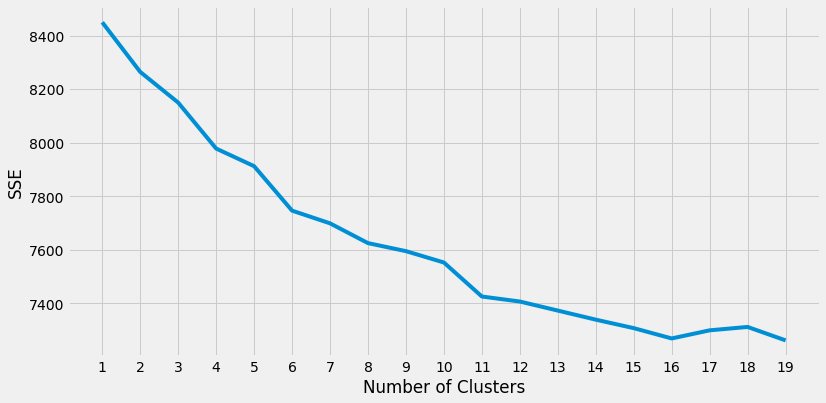

In [43]:
import matplotlib.pyplot as plt


plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,6))
plt.plot(range(1, 20), scores)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()